#### This notebook takes in model features and scales it in a suitable way for our ML model

In [225]:
import pandas as pd
import numpy as np 

df = pd.read_parquet("../data/processed/model_features.parquet")
df.sample(5)

,last_purchase_date,purchase_recency,transaction_count,quantity,payment_method_count,promo_usage_count,customer_tenure,total_spent,future_spend
30852,2021-12-24 11:00:00,7.541396,5,19,1,10,179.957172,2187.728,403.240
8068,2021-12-08 10:46:00,23.550821,6,8,2,3,313.680625,170.108,271.126
26647,2021-10-03 09:54:00,89.587003,3,6,1,0,218.517315,131.144,219.574
15821,2021-11-22 01:20:00,39.943963,1,3,1,0,39.943963,34.722,59.923
26048,2021-07-30 08:21:00,154.652041,1,1,1,0,154.652041,5.095,0.000


__Let's visualize customer tenure distribution since we just added it as a model feature__

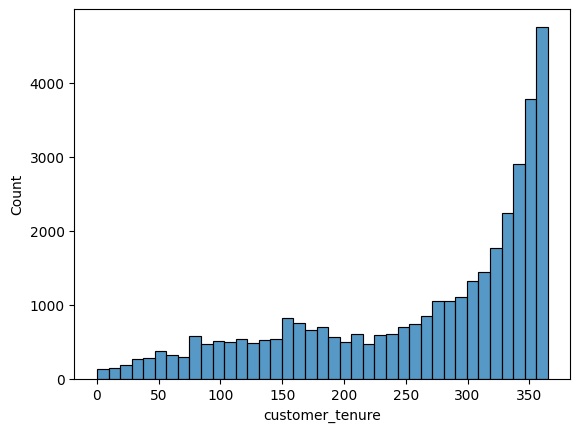

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df["customer_tenure"])
plt.show()

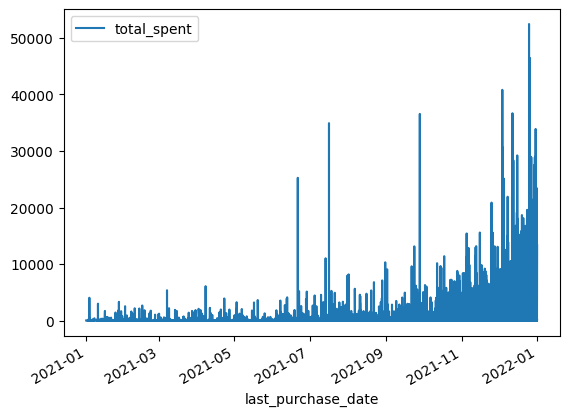

In [227]:
df.plot(x="last_purchase_date", y="total_spent")
plt.show()

__We will sort the dataframe by the customer's last purchase date since the data is based off of purchase time and different customers' purchase patterns may change over time and seasons. e.g transactions during summer may be different from those during the December holidays__

In [228]:
df = df.sort_values(by="last_purchase_date").reset_index(drop=True)
df

,last_purchase_date,purchase_recency,transaction_count,quantity,payment_method_count,promo_usage_count,customer_tenure,total_spent,future_spend
0,2021-01-01 01:14:00,364.948454,1,4,1,1,364.948454,58.543,0.000
1,2021-01-01 09:21:00,364.610004,1,2,1,2,364.610004,74.030,0.000
2,2021-01-01 16:04:00,364.330234,1,1,1,0,364.330234,4.094,0.000
3,2021-01-02 01:37:00,363.932382,1,1,1,0,363.932382,14.923,0.000
4,2021-01-02 09:29:00,363.604602,1,2,1,0,363.604602,35.029,0.000
...,...,...,...,...,...,...,...,...,...
36081,2021-12-31 23:53:00,0.004461,39,116,3,19,360.318883,7082.052,500.983
36082,2021-12-31 23:54:00,0.004067,17,43,3,7,102.036880,2084.390,998.193
36083,2021-12-31 23:54:00,0.003747,118,239,5,37,363.121734,13513.165,1866.608
36084,2021-12-31 23:56:00,0.002516,20,34,4,5,137.941532,502.177,760.096


In [229]:
log_features = ["transaction_count", "quantity", 
                "total_spent", "customer_tenure", "purchase_recency"]     
# these features a really right-skewed (from EDA notebook) so we log it to normalize its distribution

scale_features = ["payment_method_count", "promo_usage_count"]

# future_spend (the target) is not included

__We'll be setting up transformers inside a pipeline instead of doing it openly (helps avoid possible data leakage)__

In [230]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



# Applies np.log1p() to each feature to deal with outliers, then performs standard scaler on the logged values to keep variation between 0 and 1 still.
log_transformer = Pipeline(steps=[
    ("log", FunctionTransformer(np.log1p)),     # performs log only on the features that require it
    ("scaler", StandardScaler())
])

scale_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())    # Only scales particular features, ones that don't need logging 
])


In [231]:
preprocessor = ColumnTransformer(
    transformers=[
        ("log_features", log_transformer, log_features),
        ("scale_features", scale_transformer, scale_features),
    ]
)
preprocessor

ColumnTransformer(transformers=[('log_features',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('scaler', StandardScaler())]),
                                 ['transaction_count', 'quantity',
                                  'total_spent', 'customer_tenure',
                                  'purchase_recency']),
                                ('scale_features',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['payment_method_count',
                                  'promo_usage_count'])])

__We are going to split data into train and test sets based on last purchase date, not randomly with train test split so the model can also learn seasonal patterns__

In [232]:
df.columns

Index(['last_purchase_date', 'purchase_recency', 'transaction_count',
       'quantity', 'payment_method_count', 'promo_usage_count',
       'customer_tenure', 'total_spent', 'future_spend'],
      dtype='object')

In [233]:
X = df.drop(columns=["future_spend", "last_purchase_date"])
y = df["future_spend"]

#### <h3 style = "text-align:center;"> Splitting the data (Time Series Split) </h3>

In [234]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, n_jobs=4, verbosity=1)
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", xgb)])


tscv = TimeSeriesSplit(n_splits=6)

mae_scores = []
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", xgb)])

    pipeline.fit(X_train, y_train)

    preds = pipeline.predict(X_val)

    mae  = mean_absolute_error(y_val, preds)
    rmse = root_mean_squared_error(y_val, preds)

    mae_scores.append(mae)
    rmse_scores.append(rmse)



    print("\n=======================================")
    print(f"Fold {fold}")
    print(f"Train period: {X_train.index.min()} → {X_train.index.max()}")
    print(f"Val period:   {X_val.index.min()} → {X_val.index.max()}\n")
    print(f"MAE for fold:  {mae}")
    print(f"rmse for fold:  {rmse}")


print("\nAverage performance")
print("MAE :", np.mean(mae_scores))
print("RMSE:", np.mean(rmse_scores))


Fold 0
Train period: 0 → 5155
Val period:   5156 → 10310

MAE for fold:  25.515682217215524
rmse for fold:  50.00827987268725

Fold 1
Train period: 0 → 10310
Val period:   10311 → 15465

MAE for fold:  70.1193117879057
rmse for fold:  100.75899039653976

Fold 2
Train period: 0 → 15465
Val period:   15466 → 20620

MAE for fold:  67.20888476433187
rmse for fold:  99.9637930526582

Fold 3
Train period: 0 → 20620
Val period:   20621 → 25775

MAE for fold:  82.79999286485011
rmse for fold:  125.7603930877932

Fold 4
Train period: 0 → 25775
Val period:   25776 → 30930

MAE for fold:  112.2927742611447
rmse for fold:  169.8352765960327

Fold 5
Train period: 0 → 30930
Val period:   30931 → 36085

MAE for fold:  155.03647532411236
rmse for fold:  232.2854448874392

Average performance
MAE : 85.49552020326003
RMSE: 129.76869631552503


### Splitting by date

In [235]:
# X_train = train_df.drop(columns=["future_spend", "last_purchase_date"])
# y_train = train_df["future_spend"]

# X_test  = test_df.drop(columns=["future_spend", "last_purchase_date"])
# y_test  = test_df["future_spend"]

# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("\nX_test shape: ", X_test.shape)
# print("y_test shape: ", y_test.shape)

===========================================================================================================

### Fitting and preprocess data with linear regression model